### MNIST  распознавание рукописного ввода 

Построить классификатор изображений рукописного ввода на базе MNIST. 

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей. Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например,  результат PCA преобразования.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from functools import partial

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from warnings import filterwarnings 
filterwarnings('ignore')

In [2]:
import os     
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = np.loadtxt('/content/drive/My Drive/CV_HW_2/train.csv', delimiter=',', skiprows=1)
test  = np.loadtxt('/content/drive/My Drive/CV_HW_2/test.csv', delimiter=',', skiprows=1)

In [4]:
test.shape

(28000, 784)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(np.resize(train_img, (train.shape[0], 28*28)), 
                                                      train_label, 
                                                      test_size=0.20, 
                                                      random_state=42)

In [7]:
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = KNeighborsClassifier(n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
#clf3 = GaussianNB()
clf4 = XGBClassifier(n_jobs=-1)

In [9]:
eclf2 = VotingClassifier(estimators=[
         ('knn', clf1), ('rf', clf2), ('xgb', clf4)], voting='hard')

eclf2.fit(X_train,  y_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,


In [10]:
for clf, label in zip([clf1, clf2, clf4, eclf2], ['KNeighborsClassifier', 'Random Forest', 'XG boost', 'Ensemble']):
     scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.00) [KNeighborsClassifier]
Accuracy: 0.96 (+/- 0.00) [Random Forest]
Accuracy: 0.93 (+/- 0.00) [XG boost]
Accuracy: 0.96 (+/- 0.00) [Ensemble]


In [11]:
confusion_matrix(eclf2.predict(X_valid),y_valid)

array([[807,   0,   3,   1,   1,   3,   5,   1,   1,   3],
       [  0, 904,   6,   2,   1,   1,   1,  10,   7,   4],
       [  1,   2, 813,   8,   1,   2,   0,   9,   5,   1],
       [  0,   0,   3, 884,   0,  12,   0,   1,  11,  13],
       [  0,   1,   7,   0, 811,   0,   1,   4,   6,   9],
       [  1,   1,   0,  14,   0, 667,   4,   0,   4,   2],
       [  4,   1,   4,   0,   6,   9, 768,   0,   4,   0],
       [  0,   0,   8,   8,   1,   1,   0, 847,   2,   9],
       [  2,   0,   2,  10,   0,   3,   6,   1, 788,   3],
       [  1,   0,   0,  10,  18,   4,   0,  20,   7, 794]])

In [12]:
y_pred=eclf2.predict(X_valid)

In [13]:
def draw_numbers(X,y_test,y_pred,row=5,col=4):
    fig = plt.figure(figsize=(20, 10))
    ax = []
    for i, img in enumerate(X[0:row*col], 1):
        ax.append( fig.add_subplot(row, col, i) )
        ax[-1].set_title('y_p '+str(y_pred[i - 1])+';'+'y_t '+str(y_test[i - 1])) 
        plt.axis('off')
        plt.imshow(img, cmap='gray')

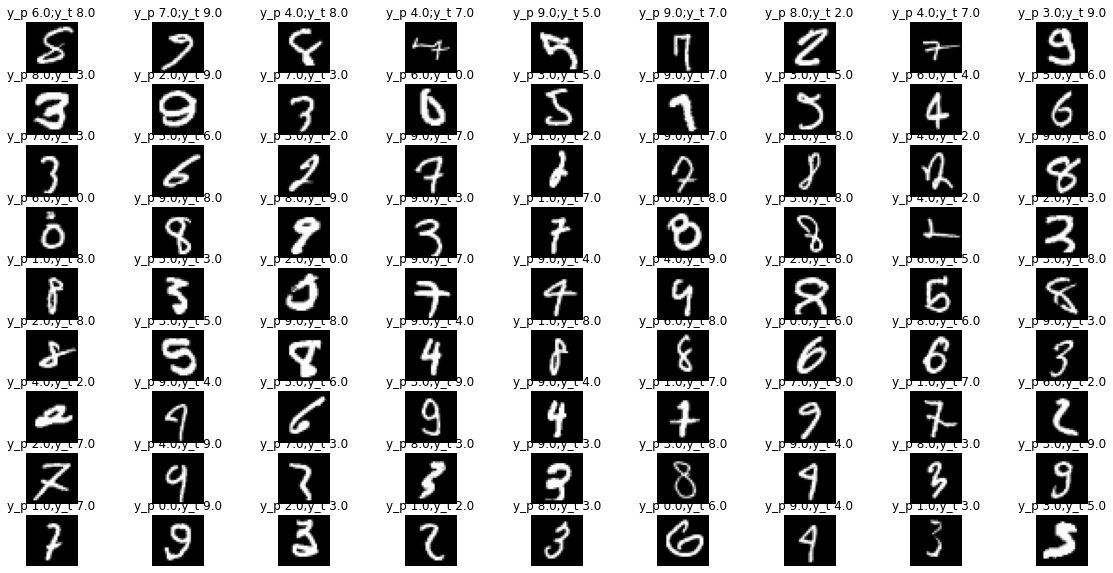

In [14]:
draw_numbers(np.resize(X_valid[np.where( y_pred!= y_valid )], 
                       (X_valid[np.where( y_pred!= y_valid )].shape[0], 28, 28)),
                        y_valid[np.where( y_pred!= y_valid )],
                        y_pred[np.where( y_pred!= y_valid)],
                        6,6)

In [32]:
pred_test_1 = eclf2.predict(np.resize(test_img, (test_img.shape[0], 28*28)))

In [33]:
with open('/content/drive/My Drive/CV_HW_2/submit_vote_knn_rf_xgb.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test_1, 1):
        dst.write('%s,%s\n' % (i, int(p) ))

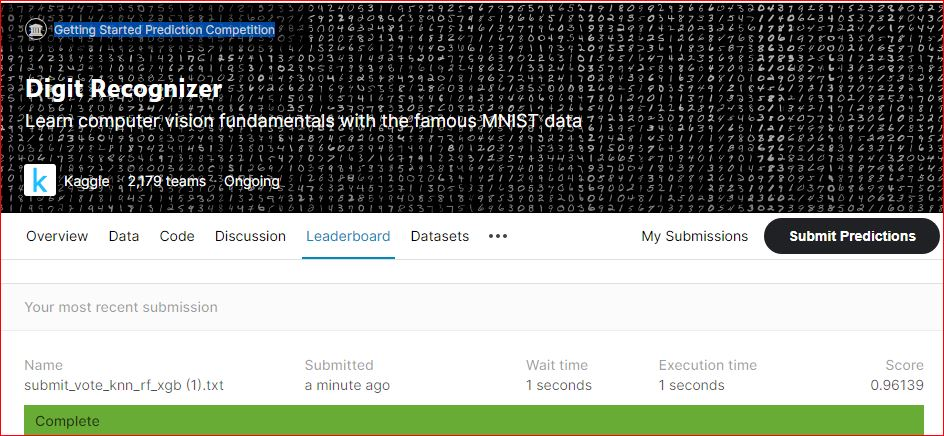

In [1]:
from IPython.display import Image
Image('kaggle_1.jpg')

In [16]:
from sklearn.decomposition import PCA

In [17]:
n_components_=[1,3,5,10,20,40,50,70,100]
valid_scores_ = np.zeros(len(n_components_))
cross_val_scores_=np.zeros(len(n_components_))


estimators = {   'eclf_2': VotingClassifier(estimators=[
                ('knn', clf1), ('rf', clf2), ('xgb', clf4)], voting='hard')
            }

In [18]:
#Подберем лучшее число компонент
for i, n_components in enumerate(n_components_):
    pca = PCA(n_components=n_components) #, whiten=True
    pca.fit(np.resize(train_img, (train.shape[0], 28*28)))
    transform = pca.transform(np.resize(train_img, (train.shape[0], 28*28)))
    X_train, X_valid, y_train, y_valid =train_test_split(transform , train_label, test_size=0.20, random_state=42)

    for est in estimators:
        globals()[est+'_pca_n_components_'+str(n_components)]=estimators[est]
        eval(est+'_pca_n_components_'+str(n_components)).fit(X_train,y_train)
        valid_score=accuracy_score(y_valid, eval(est+'_pca_n_components_'+str(n_components)).predict(X_valid))
        cross_val_scores = cross_val_score(eval(est+'_pca_n_components_'+str(n_components)), X_train, y_train, cv=5,n_jobs=-1)
        print('n_components',n_components)
        print(cross_val_scores)
        valid_scores_[i]=valid_score
        cross_val_scores_[i]=cross_val_scores.mean()
        print(est+' Mean_cross_val_Accuracy ',cross_val_scores.mean(),' Valid_Accuracy: ' ,valid_score)

n_components 1
[0.28125    0.28363095 0.28482143 0.27217262 0.271875  ]
eclf_2 Mean_cross_val_Accuracy  0.27874999999999994  Valid_Accuracy:  0.28095238095238095
n_components 3
[0.50386905 0.51354167 0.5110119  0.51056548 0.50178571]
eclf_2 Mean_cross_val_Accuracy  0.5081547619047619  Valid_Accuracy:  0.5092857142857142
n_components 5
[0.74315476 0.746875   0.75104167 0.75074405 0.75014881]
eclf_2 Mean_cross_val_Accuracy  0.7483928571428572  Valid_Accuracy:  0.7463095238095238
n_components 10
[0.89910714 0.90104167 0.90550595 0.90877976 0.9046131 ]
eclf_2 Mean_cross_val_Accuracy  0.9038095238095238  Valid_Accuracy:  0.905952380952381
n_components 20
[0.93735119 0.94166667 0.94568452 0.94404762 0.94970238]
eclf_2 Mean_cross_val_Accuracy  0.9436904761904762  Valid_Accuracy:  0.9453571428571429
n_components 40
[0.94166667 0.94866071 0.94925595 0.95044643 0.95327381]
eclf_2 Mean_cross_val_Accuracy  0.9486607142857142  Valid_Accuracy:  0.9508333333333333
n_components 50
[0.94449405 0.948809

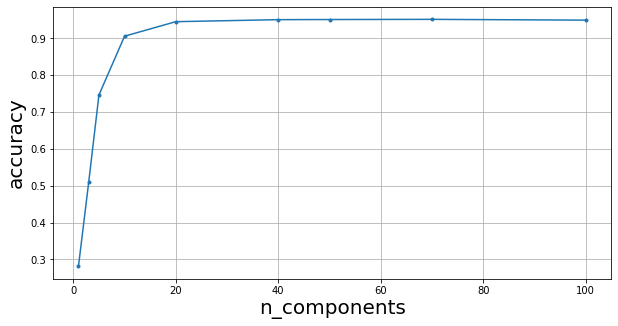

In [19]:
plt.figure(figsize=(10,5))
plt.plot(n_components_,valid_scores_,'.-')
#plt.plot(n_components_,cross_val_scores_,'k.-')
plt.xlabel("n_components", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(which="both")

In [20]:
for x,y in zip(valid_scores_,n_components_):
    if x==valid_scores_.max():
        print(x,y)

0.9516666666666667 70
